# A4: FluxModels demo

# Introduction

This notebook contains a description of the FluxModels module. This module contains classes for FBA, $^{13}$C MFA, and 2S-$^{13}$C MFA models, as well as for ELVA models. Each of this models has a corresponding results class: FBAResults, FVAResults, C13FVAResults, TSFVAResults, C13Results, TSResults, ELVAResults.

# Setup

First, we need to set the path and environment variable properly:

In [1]:
quantmodelDir = '/users/hgmartin/libraries/quantmodel'

This is the only place where the jQMM library path needs to be set.

In [2]:
%matplotlib inline

import sys, os
pythonPath = quantmodelDir+"/code/core"
if pythonPath not in sys.path:
    sys.path.append(pythonPath)
os.environ["QUANTMODELPATH"] = quantmodelDir

Then import the needed classes:

In [3]:
import FluxModels as FM
import enhancedLists, ReactionNetworks

And move to a scratch directory (to make things faster):

In [4]:
cd /scratch/hgmartin_scratch/tests

/scratch/hgmartin_scratch/tests


# Classes description

FluxModel represents the base class form which all other model classes are derived, but it is never used by itself. We will, hence, skip its description and demonstrate the classes that are actually used for flux calculations

## FBAModel, FBAresults and FVAresults

These classes are used for Flux Balance Analysis (FBA) and Flux Variability Analysis (FVA) calculations. For example: 

In [5]:
qmodeldir         = os.environ['QUANTMODELPATH']
basedir           = qmodeldir+'/data/tests/Toya2010/2S/'
testdir           = basedir + '2SpaperTest/'

FBAfileName = testdir+'XML/'+'EciJR904wt5hGrowthPartial.xml'    
FBAmodel    = FM.FBAModel(FBAfileName)

gets us an FBA model, and we can find fluxes by doing:

In [6]:
FBAresults  = FBAmodel.findFluxes()
fluxDictFBA = FBAresults.reactionNetwork.reactionList.getFluxDictionary()

In [7]:
print fluxDictFBA['PGI'].net

4.8848561646


In the same fashion, we can obtain the FVA results by doing:

In [8]:
FVAresults   = FBAmodel.FVA(['PDH','PGI','MDH'])
fluxDictFVA = FVAresults.reactionNetwork.reactionList.getReactionDictionary()

In [9]:
for name in ['PDH','PGI','MDH']:
    print name+": "+str(fluxDictFVA[name].flux.net)

PDH: [0:10.2006036871:18.6327817768]
PGI: [-6.98668484257:4.8848561646:11.5384750666]
MDH: [-8.28839116417:2.79597922572:29.2100898247]


One can use the **changeObjective** function to change the objective:

In [10]:
FBAmodel.changeObjective('BiomassEcoli',0)
FBAmodel.changeObjective('PDH',1)

In [11]:
FBAresults2 = FBAmodel.findFluxes()
fluxDictFBA2 = FBAresults2.reactionNetwork.reactionList.getFluxDictionary()

In [12]:
print fluxDictFBA['PDH'].net
print fluxDictFBA2['PDH'].net

10.2006036871
42.5


and the **printSuccess** method to print if the run was successful:

In [13]:
FBAresults.printSuccess(onlyFail=False)

lp successful


## C13Model, C13Results, C13FVAResults

These classes are used for $^{13}$C Metabolic Flux Analysis ($^{13}$C MFA) and $^{13}$C Flux variability Analysis ($^{13}$C FVA). 

For example, we can load the toy TCA cycle model:

In [14]:
qmodeldir         = os.environ['QUANTMODELPATH']    
dirDATA           = qmodeldir+'/data/tests/TCAtoy/' 

REACTIONSfilename   = dirDATA+'REACTIONStca.txt' 
FEEDfilename        = dirDATA+'FEEDtca.txt'
CEMSfilename        = dirDATA+'GCMStca.txt'
CEMSSTDfilename     = dirDATA+'GCMSerrtca.txt'
FLUXESFreefilename  = dirDATA+'FLUXtca.txt'

atomTransitions = enhancedLists.AtomTransitionList(REACTIONSfilename)
ReacNet = ReactionNetworks.C13ReactionNetwork(atomTransitions.getReactionNetwork('E. coli wt5h 13C MFA'))

ReacNet.addLabeling(CEMSfilename,'LCMSLabelData',CEMSSTDfilename,minSTD=0.001)
ReacNet.addFeed(FEEDfilename)
ReacNet.loadFluxBounds(FLUXESFreefilename)

ReacNet.write('TCA.sbml') 

1

In [15]:
C13model = FM.C13Model('TCA.sbml')

And then calculate fluxes and use **findFluxesStds** to calculate fluxes and standard deviations through the monte carlo approach:

In [16]:
%%time
results    = C13model.findFluxesStds(Nrep=10, procString='proc', erase=True)

CPU times: user 1.18 s, sys: 2.11 s, total: 3.29 s
Wall time: 6.83 s


**plotExpvsCompLabelFragment** and **plotExpvsCompLabelXvsY** provide alternative ways to see the fits: 

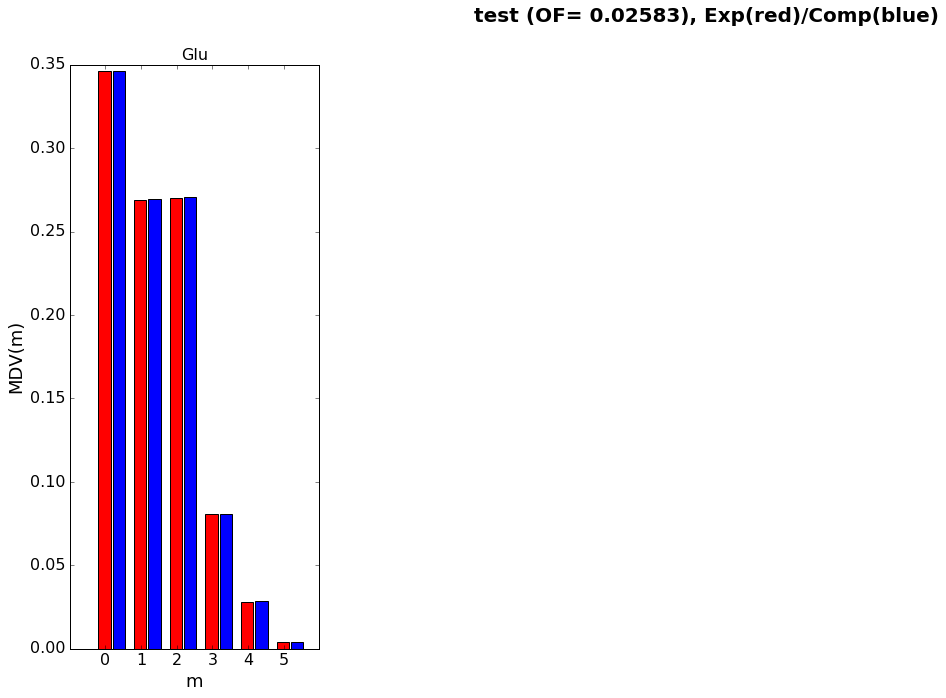

In [17]:
results.plotExpvsCompLabelFragment(titleFig='test')

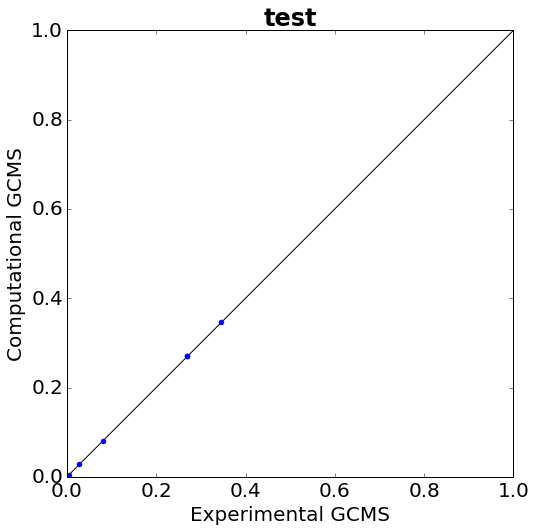

In [18]:
results.plotExpvsCompLabelXvsY(titleFig='test')

Results are stored in a reaction network where all ReactionNetworks methods are available:

In [19]:
results.reactionNetwork.reactionList.printFluxes(brief="False")

co2Out: 	150.0
r6: 	125.0
r1: 	100.0
r2: 	100.0
r7: 	75.0
r4: 	50.0
r5: 	50.0
r3: 	50.0
r8: 	50.0


In [20]:
results.EMUlabel['Glu']

array([ 0.34635,  0.26953,  0.27083,  0.08073,  0.02865,  0.00391])

In [21]:
results.fragDict['Glu'].mdv

array([ 0.346,  0.269,  0.27 ,  0.081,  0.028,  0.004])

A more detailed demonstration of these classes can be found in notebooks B2 and B3.

## TwoSC13Model, TSResults, TSFVAResults

These are the classes used for two-scale $^{13}$C Metabolic Flux Analysis (2S-$^{13}$C MFA).

Here, we offer a quick demonstration using the data from Toya *et al*. 2007. Notebook B4 offers a more complete demonstrating by regenerating all figures from Garcia Martin *et al*. 2015. Let's start by getting the input data from several files and blend them into a single sbml file:


In [22]:
datadir = os.environ['QUANTMODELPATH']+'/data/tests/Toya2010/2S/wt5h/'
strain ='wt5h'

BASEfilename      = datadir + 'EciJR904TKs.xml'
FLUXESfilename    = datadir + 'FLUX'+strain+'.txt'
REACTIONSfilename = datadir + 'REACTIONS'+strain+'.txt'      
MSfilename        = datadir + 'GCMS'+strain+'.txt'
FEEDfilename      = datadir + 'FEED'+strain+'.txt'
MSSTDfilename     = datadir + 'GCMSerr'+strain+'.txt'

In [23]:
# Load initial SBML file
reacNet = ReactionNetworks.TSReactionNetwork(BASEfilename)
    
# Add Measured fluxes
reacNet.loadFluxBounds(FLUXESfilename)
# Add carbon transitions
reacNet.addTransitions(REACTIONSfilename)
# Add measured labeling information
reacNet.addLabeling(MSfilename,'LCMSLabelData',MSSTDfilename,minSTD=0.001)
# Add feed labeling information
reacNet.addFeed(FEEDfilename)
 

# Limit fluxes to 500       
reacNet.capFluxBounds(500)

# Creates sbml file to create the model. All files in the library can be represented by a file name or
#a tuple of the type: (fileName, string of contents)
SBMLfile = ('EciJR904TKs'+strain+'TS.xml',reacNet.write('toString'))

TSmodel  = FM.TwoSC13Model(('EciJR904TKs'+strain+'TS.xml',reacNet.write('toString'))) 

and then use the file to create the two-scale model:

In [24]:
TSmodel  = FM.TwoSC13Model(('EciJR904TKs'+strain+'TS.xml',reacNet.write('toString'))) 

We can then use the **findFluxesRanges** method to fit fluxes and find the ranges compatible with labeling data:

In [25]:
fluxNames = TSmodel.reactionNetwork.C13ReacNet.reactionList.getReactionNameList(level=1)
TSresult = TSmodel.findFluxesRanges(Nrep=30,fluxNames=fluxNames,procString='proc') 

And see the fits with the **plotExpvsCompLabelFragment** method:

CPU times: user 824 ms, sys: 12 ms, total: 836 ms
Wall time: 829 ms


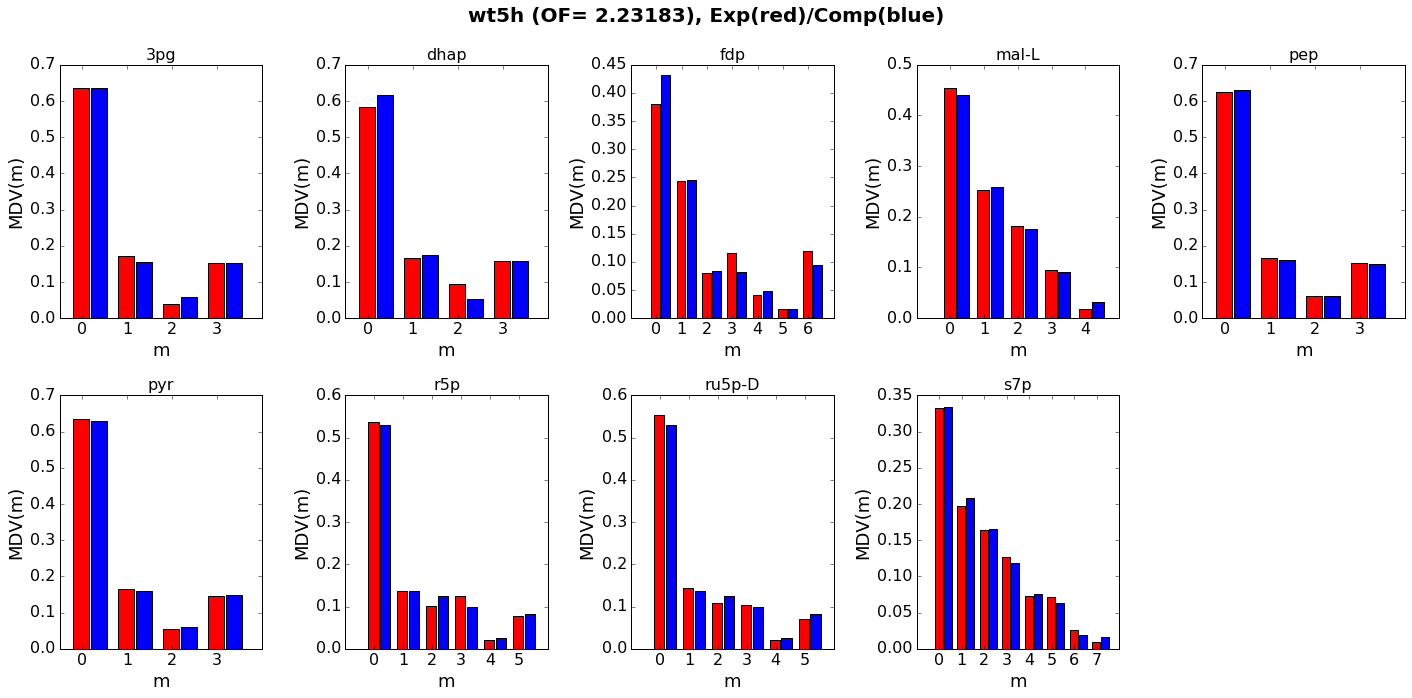

In [26]:
%%time
TSresult.plotExpvsCompLabelFragment(titleFig='wt5h')